# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

Were going to code by hand this one:

[conv-relu-conv-relu-pool]x3 - [affine]x2 - [softmax or SVM]

Weights in repeated stack:

    conv - W_s_1, b_s_1  
    sbn - gamma_s_1, beta_s_1
    conv - W_s_2, b_s_2
    sbn - gamma_s_2, beta_s_2

    affine - W3, b3, gamma_3, beta_3
    affine - W4, b4, gamme_4, beta_4


    Stack 1
    I(N, C, H, W) => CONV(N, F, H, W) ... => MAX_POOL(N, F, HP_1, WP_1)
    Stack 2
    I(N, F, HP_1, WP_1) => MAX_POOL(N, F, HP_2, WP_2)
    Stack 3
    I(N, F, HP_2, WP_2) => MAX_POOL(N, F, HP_3, WP_3)

Which image 3x32x32 pool => 3x16x16 => 3x8x8 => 3x4x4
                               HW_1    H_2      H_3
                              
    Affine 1
    POOL(N, F, 4, 4) => AFFINE(N, NH)
    Affine 2
    AFFINE(H, NH) => AFFINE(N, K)



## Sanity check loss
After you build a new network, one of the first things you should do is sanity check 
the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [10]:
N, C, H, W = 50, 3, 32, 32
F = 22
NH = 5
num_conv_layers=2
num_classes=10

model = ThreeLayerConvNet(
    input_dim=(C, H, W),
    hidden_dim=NH, 
    num_filters=F, 
    num_conv_layers=num_conv_layers)

for k, v in iter(sorted(model.params.iteritems())):
  print "%s %s " % (k, model.params[k].shape)


N = 50
X = np.random.randn(N, C, H, W)
y = np.random.randint(num_classes, size=N)
print "y.shape", y.shape


loss, grads = model.loss(X, y)
print 'Initial loss (no regularization): ', loss

model.reg = 1e1
loss, grads = model.loss(X, y)
print 'Initial loss (with regularization): ', loss

W_0_1 (22, 3, 7, 7) 
W_0_2 (22, 22, 7, 7) 
W_1_1 (22, 22, 7, 7) 
W_1_2 (22, 22, 7, 7) 
W_2 (1408, 5) 
W_3 (5, 10) 
b_0_1 (22,) 
b_0_2 (22,) 
b_1_1 (22,) 
b_1_2 (22,) 
b_2 (5,) 
b_3 (10,) 
beta_0_1 (22,) 
beta_0_2 (22,) 
beta_1_1 (22,) 
beta_1_2 (22,) 
beta_2 (5,) 
beta_3 (10,) 
gamma_0_1 (22,) 
gamma_0_2 (22,) 
gamma_1_1 (22,) 
gamma_1_2 (22,) 
gamma_2 (5,) 
gamma_3 (10,) 
y.shape (50,)
Initial loss (no regularization):  2.35362324656
Initial loss (with regularization):  2.75922482501


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [16]:
N, C, H, W = (2, 3, 16, 16)
F = 6
NH = 4
reg = 0.0
num_classes = 10
num_conv_layers=2

X = 1e-3 * np.random.randn(N, C, H, W) + 10
y = np.random.randint(num_classes, size=N)

model = ThreeLayerConvNet(
    num_filters=F, 
    filter_size=3,
    input_dim=(C, H, W), 
    hidden_dim=NH,
    num_conv_layers=num_conv_layers,
    weight_scale = 1e-3,
    dtype=np.float64)

loss, grads = model.loss(X, y)
num_grads = {}
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))
    num_grads[param_name] = param_grad_num


W_0_1 max relative error: 7.561810e-07
W_0_2 max relative error: 1.962260e-05
W_1_1 max relative error: 3.417883e-04
W_1_2 max relative error: 3.428771e-05
W_2 max relative error: 1.915623e-06
W_3 max relative error: 1.258837e-07
b_0_1 max relative error: 2.220449e-02
b_0_2 max relative error: 2.220475e-02
b_1_1 max relative error: 2.531308e-06
b_1_2 max relative error: 2.220439e-02
b_2 max relative error: 1.776357e-07
b_3 max relative error: 1.421085e-06
beta_0_1 max relative error: 2.392398e-03
beta_0_2 max relative error: 8.026460e-04
beta_1_1 max relative error: 1.171868e-04
beta_1_2 max relative error: 2.220446e-02
beta_2 max relative error: 2.096336e-09
beta_3 max relative error: 3.235019e-09
gamma_0_1 max relative error: 2.253567e-05
gamma_0_2 max relative error: 1.647877e-04
gamma_1_1 max relative error: 9.694680e-06
gamma_1_2 max relative error: 7.309977e-05
gamma_2 max relative error: 4.853969e-05
gamma_3 max relative error: 1.852179e-04


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [17]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 20) loss: 2.414886
(Epoch 0 / 10) train acc: 0.230000; val_acc: 0.093000
(Iteration 2 / 20) loss: 2.134819
(Epoch 1 / 10) train acc: 0.350000; val_acc: 0.122000
(Iteration 3 / 20) loss: 1.726520
(Iteration 4 / 20) loss: 1.741869
(Epoch 2 / 10) train acc: 0.340000; val_acc: 0.155000
(Iteration 5 / 20) loss: 1.744043
(Iteration 6 / 20) loss: 1.517836
(Epoch 3 / 10) train acc: 0.380000; val_acc: 0.150000
(Iteration 7 / 20) loss: 1.578848
(Iteration 8 / 20) loss: 1.465975
(Epoch 4 / 10) train acc: 0.420000; val_acc: 0.150000
(Iteration 9 / 20) loss: 1.288769
(Iteration 10 / 20) loss: 1.209198
(Epoch 5 / 10) train acc: 0.470000; val_acc: 0.165000
(Iteration 11 / 20) loss: 1.185137
(Iteration 12 / 20) loss: 1.080347
(Epoch 6 / 10) train acc: 0.560000; val_acc: 0.191000
(Iteration 13 / 20) loss: 1.060817
(Iteration 14 / 20) loss: 0.965054
(Epoch 7 / 10) train acc: 0.690000; val_acc: 0.188000
(Iteration 15 / 20) loss: 1.016992
(Iteration 16 / 20) loss: 1.005805
(Epoch 8 / 10) tr

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

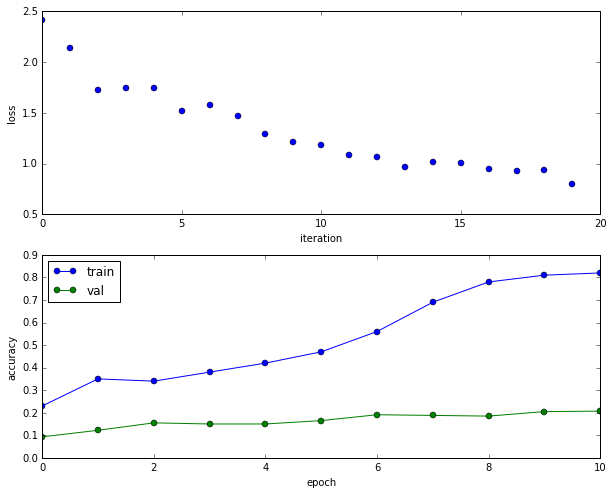

In [18]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [3]:
from time import time

def random_in_range(a, b):
    assert b > a
    return (b - a) * np.random.random_sample() + a

best_val_acc = 0 
best_solver = None
solvers = []

num_runs = 5
for i in range(num_runs):
  
    hidden_dim = 150
    #reg = 10 ** -random_in_range(0, 1)
    reg = 0.000432040462195
    # learning_rate = 10 ** -random_in_range(3, 4)
    learning_rate = 0.000274963796444
    update_rule = 'rmsprop'
    filter_size = 5
    num_filters = 25
    num_epochs = 12
    num_conv_layers = 3

    run_results = [hidden_dim, reg, learning_rate, 
                   filter_size, num_filters, num_epochs, num_conv_layers]
    print "Starting", run_results
    
    start = time()
    print "start time", start
        
    model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=hidden_dim, 
                              reg=reg, filter_size=filter_size, 
                              num_filters=num_filters)
    solver = Solver(model, data,
                    num_epochs=num_epochs, batch_size=200,
                    update_rule=update_rule,
                    optim_config={
                      'learning_rate': learning_rate,
                    },
                    lr_decay=0.95,
                    verbose=True, print_every=20)
    solver.train()
    
    elapsed = time() - start
    print "elapsed time", elapsed
    run_results.append(elapsed)

    solvers.append(solver)
    val_acc = solver.val_acc_history[-1]
    run_results.append(solver.loss_history[-1])
    run_results.append(solver.train_acc_history[-1])
    run_results.append(val_acc)
    
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_solver = solver
    
    
    print "Ending", run_results
    with open('run-results.txt', 'a') as run_file:
        run_file.write('[' + ', '.join([str(x) for x in run_results]) + ']\n')


Starting [150, 0.000432040462195, 0.000274963796444, 5, 25, 12, 3]
start time 1481502164.66
(Iteration 1 / 2940) loss: 2.465120
(Epoch 0 / 12) train acc: 0.091000; val_acc: 0.098000
(Iteration 21 / 2940) loss: 1.813599
(Iteration 41 / 2940) loss: 1.737233
(Iteration 61 / 2940) loss: 1.622377
(Iteration 81 / 2940) loss: 1.562298
(Iteration 101 / 2940) loss: 1.585774
(Iteration 121 / 2940) loss: 1.533355
(Iteration 141 / 2940) loss: 1.451031
(Iteration 161 / 2940) loss: 1.384999
(Iteration 181 / 2940) loss: 1.354058
(Iteration 201 / 2940) loss: 1.428368
(Iteration 221 / 2940) loss: 1.452159
(Iteration 241 / 2940) loss: 1.345347
(Epoch 1 / 12) train acc: 0.612000; val_acc: 0.591000
(Iteration 261 / 2940) loss: 1.365664
(Iteration 281 / 2940) loss: 1.301868
(Iteration 301 / 2940) loss: 1.353366
(Iteration 321 / 2940) loss: 1.272909
(Iteration 341 / 2940) loss: 1.261249
(Iteration 361 / 2940) loss: 1.245762
(Iteration 381 / 2940) loss: 1.154994
(Iteration 401 / 2940) loss: 1.247222
(Iterati

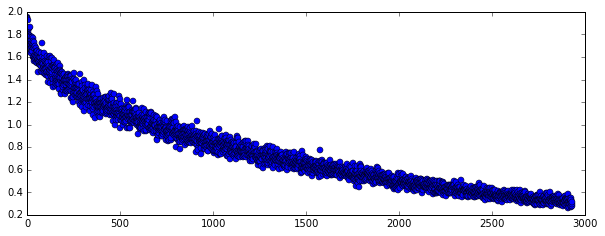

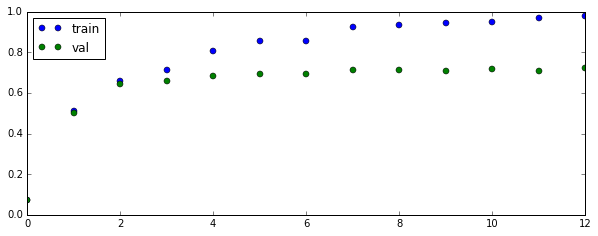

[0.074999999999999997, 0.51100000000000001, 0.65800000000000003, 0.71599999999999997, 0.80700000000000005, 0.85799999999999998, 0.85799999999999998, 0.92600000000000005, 0.93300000000000005, 0.94499999999999995, 0.94999999999999996, 0.97199999999999998, 0.97999999999999998]
[0.071999999999999995, 0.5, 0.64500000000000002, 0.65700000000000003, 0.68500000000000005, 0.69399999999999995, 0.69399999999999995, 0.71299999999999997, 0.71599999999999997, 0.70799999999999996, 0.72099999999999997, 0.70999999999999996, 0.72199999999999998]


In [4]:
solver = best_solver

plt.subplot(2, 1, 1)
plt.plot(solver.loss_history[10:], 'o')
plt.show()

# plt.subplot(2, 1, 2)
# plt.plot(solver.train_acc_history)
# plt.show()

train = np.array(solver.train_acc_history)
val = np.array(solver.val_acc_history)

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, 'o')
plt.plot(solver.val_acc_history, 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print solver.train_acc_history
print solver.val_acc_history



## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

(25, 3, 5, 5)


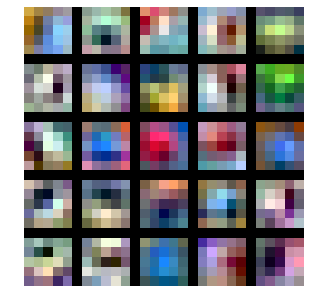

In [5]:
from cs231n.vis_utils import visualize_grid

model = best_solver.model

print model.params['W_0_1'].shape

grid = visualize_grid(model.params['W_0_1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Experiment!
Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:

### Things you should try:
- Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Batch normalization: Try adding spatial batch normalization after convolution layers and vanilla batch normalization aafter affine layers. Do your networks train faster?
- Network architecture: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file `cs231n/classifiers/convnet.py`. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, or MaxOut.
- Model ensembles
- Data augmentation

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training, validation, and test set accuracies for your final trained network. In this notebook you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Have fun and happy training!

##  Start with the vanilla 3 layer model and do a decent job training.




In [54]:
def plot_acc(filename):

    with open(filename, 'r') as run_file:
         lines = [line.rstrip('\n') for line in run_file]

    lines = np.array([np.array(eval(l)) for l in lines])
    print lines.shape

#     run_results = [hidden_dim, reg, learning_rate,  
#                    filter_size, num_filters, num_epochs, num_conv_layers]

#     plt.subplot(4, 2, 1)
#     plt.scatter(np.log10(lines[:, 0]), lines[:, 10])
#     plt.title("Hidden")

    plt.subplot(4, 2, 2)
    plt.scatter(np.log10(lines[:, 1]), lines[:, 10])
    plt.title("Reg")

    plt.subplot(4, 2, 3)
    plt.scatter(np.log10(lines[:, 2]), lines[:, 10])
    plt.title("Learn")

#     plt.subplot(4, 2, 4)
#     plt.scatter(lines[:, 3], lines[:, 10])
#     plt.title("Filter Size")

#     plt.subplot(4, 2, 5)
#     plt.scatter(lines[:, 4], lines[:, 10])
#     plt.title("Filter count")

#     plt.subplot(4, 2, 6)
#     plt.scatter(lines[:, 5], lines[:, 10])
#     plt.title("Epochs")

#     plt.subplot(4, 2, 7)
#     plt.scatter(lines[:, 6], lines[:, 10])
#     plt.title("Num conv layers")

    plt.show()
    

Plots of validation set accuracy.  With the vanilla net we seem to max out at 0.70 after 4 epochs.  A few runs with more epocs and more regulization also topped out under 0.7 validation accuracy.  We need a better architecture!  

(10, 11)


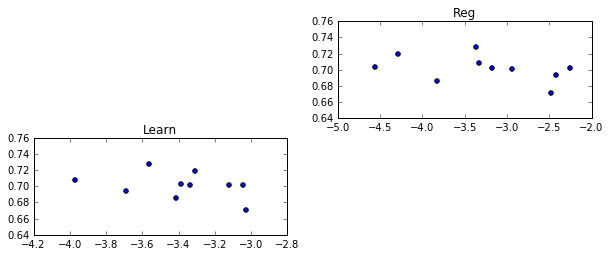

In [55]:
plot_acc('model-03-run-results-05.txt')

# Three layer net++

I'm looking at this architecture:

> [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

Let's use the three layer net and add the extra conv-relu priot to the pool.  We have small images and if we pool twice we are down to 4x4 spatial dimensions.  Maybe that's okay and many channels can make up for small spatial dimensions?  IDK, let's make the network deeper and limit ourself to 2 pooling layers.

Also add spatial normalization between both conv-relu layers combinations.


In [76]:
X = data['X_test']
y = data['y_test']

print X.shape
print y.shape

# models sorted from most accurate to least accurate
model_idx = (0, 1, 2, 3, 4)

acc = []
for num_models in range(5, 6):

    print "num_models", num_models
    y_ens_pred = np.empty((y.shape[0], num_models), dtype=int)

    for i in range(num_models):
        solver = solvers[model_idx[i]]
        scores = solver.model.loss(X)
        pred = np.argmax(scores, axis=1)
        y_ens_pred[:, i] = pred

    y_pred = np.empty_like(y)
    for i in range(y_pred.shape[0]):
        y_pred[i] = np.argmax(np.bincount(y_ens_pred[i]))

    acc.append(np.mean(y_pred == y))

print acc

(1000, 3, 32, 32)
(1000,)
num_models 5
[0.75900000000000001]


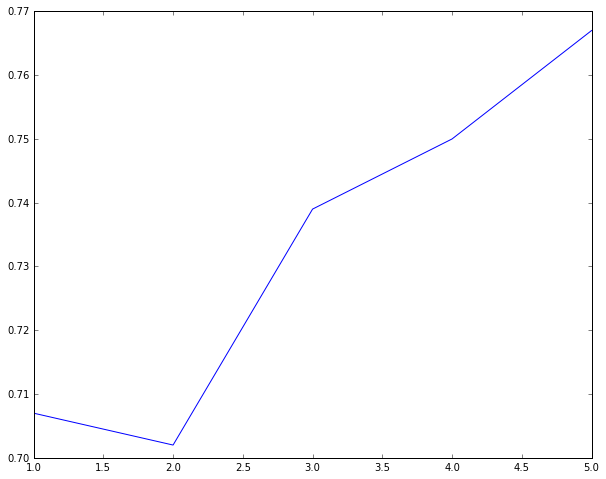

In [75]:
# plot ensamble val error versus number of models
plt.plot(range(1, 6), acc)
plt.show()